In [1]:
import os
import re
import csv
import cv2
import easyocr
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
reader = easyocr.Reader(['en'])

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


In [2]:
# directory that contains screenshots for all the stimuli
pics = os.listdir('./stimuli')
print(len(pics))

1


In [3]:
# This file contains all the information for the stimuli (fuction name, id #, summaries, code)
stimdf = pd.read_csv('pruned_seeds2.csv')
print(len(stimdf))

162


file exists


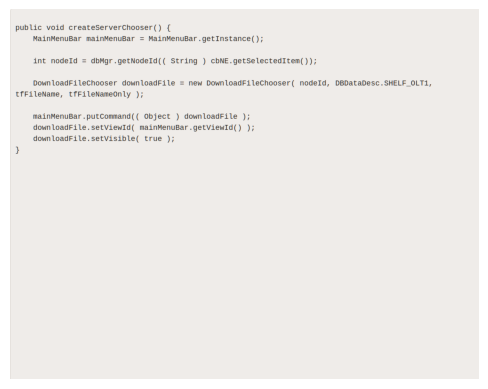

In [7]:
## read through pngs and find corresponding function
for pic in pics:
    name = re.split('.png', pic)[0]
    
    # temp contains all the images for each word, split by function name
    try:
        os.mkdir('./temp/{name}'.format(name=name))
    except:
        print("file exists")
    boxfile = '{name}_boxes.csv'.format(name=name)
    df = pd.DataFrame()
    row = np.where(stimdf['name'] == name) # finding row specific to each function
    i = row[0][0]
    func = stimdf['function'][i] # getting actual Java code for each stimulus
    split = re.split(" |\n", func) # splitting each function by spaces and newlines to get word level 
    split = list(filter(None, split))
    
    # now with all the code split up, create actual bounding boxes on images
    # basically just a pipeline with cv2
    
    img = cv2.imread('./stimuli/{pic}'.format(pic=pic)) # 
    img = img[100:1000, 10:1150]
    plt.imshow(img)
    plt.axis('off')
    break
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)
    rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (8, 8))
    dilation = cv2.dilate(thresh, rect_kernel, iterations=1)
    contours, hierarchy = cv2.findContours(dilation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    print(len(contours)) # number of words caught by bounding boxes
    
    unpredicted = 0 # need to do these manually
    for ii, box in enumerate(contours):
        box = contours[(len(contours)-1)-ii]
        x, y, w, h = cv2.boundingRect(box)  # coordinates, width, and height
        tangle = cv2.rectangle(img, (x, y), (x+w, y+h),(0, 255, 0, 2))  # drawing the rectangle
        word_img = img[y+1:(y+1)+(h-1), x+1:(x+1)+(w-1)] # actual pixel values for word
        resized = cv2.resize(word_img, (w*5, h*5),interpolation=cv2.INTER_CUBIC) # bumping up size to improve OCR

        # Convert image to grayscale
        gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
        # Apply thresholding to remove noise
        thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

        # Perform dilation to make characters more prominent
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 1))
        dilated = cv2.dilate(thresh, kernel, iterations=1)
        # We generate a copy of the image and apply a dilation kernel 
        # and median blur on it. - ChatGPT
        blurred = cv2.medianBlur(dilated, 1)
        
        # Perform erosion to remove any remaining noise
        erosion = cv2.erode(blurred, kernel, iterations=1)
        inverted = 255 - erosion

        # Perform OCR on the inverted image
        result = reader.readtext(inverted)
        
        if not result: # sometimes word was null
            #cv2.imwrite("./temp/{func}/{c}_unknown.png".format(func=name, c=unpredicted), inverted)
            temp = pd.DataFrame([['unknown_{i}'.format(i=unpredicted), x, y, w, h]]) # still adding the row
            df = pd.concat([df, temp], ignore_index=True)
            unpredicted += 1
        for r in result:
            #cv2.imwrite("./temp/{func}/{c}.png".format(c=r[1],func=name), inverted)
            temp = pd.DataFrame([[re.sub(" ", "", r[1]), x, y, w, h]])
            df = pd.concat([df, temp], ignore_index=True)

    #cv2.imwrite("./temp/{name}/{c}_func.png".format(c=name, name=name), img)
    df.columns = ['word', 'x', 'y', 'width', 'height']
    
    df = df.sort_values(['y','x']) # some characters had different heights (B vs. +), so the below code 
    count = 0                      # standardizes row values and sorts each row
    standard = df.iloc[0, 2]       # now we have bounding box files that read sequentially in order
    for i, row in df.iterrows():
        if i < len(df)-1:
            diff = df.iloc[i+1, 2]-row[2]
            if diff > 20: # heuristic for new row height
                standard = df.iloc[i+1, 2]
            else:
                row[2] = standard
                df.iloc[i+1, 2] = standard
    df = df.sort_values(['y', 'x'])
    #pd.DataFrame.to_csv(df, "./word_coordinates/{name}_boxes.csv".format(name=name))
    

In [21]:
backup = df